# Lambda Iterations

In [1]:
import os
import sys

magritteFolder = '/home/frederik/Dropbox/GitHub/Magritte/'

sys.path.append(magritteFolder)

import numpy             as np
import matplotlib.pyplot as plt
import magritte.setup    as setup
import magritte.core     as magritte

In [2]:
def max_relative_difference(a, b):
    return np.max(2.0 * np.abs((a - b) / (a + b)))

In [3]:
def VZp1_pops(nod):

    dimension = 1
    npoints   = 100
    nrays     = 200
    nspecs    = 5
    nlspecs   = 1
    nquads    = 15

    r_in   = 1.0E13   # [m]
    r_out  = 7.8E16   # [m]
    nH2_in = 2.0E13   # [m^-3]
    X_mol  = 1.0E-8   # [.]
    temp   = 20.0     # [K]
    turb   = 150.00   # [.]


    def nH2 (r):
        return nH2_in * np.power(r_in/r, 2.0)

    def nTT (r):
        return X_mol  * nH2(r)


    rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)


    modelFile = 'vanZadelhoff_1a_1D.hdf5'
    lamdaFile = f'{magritteFolder}tests/data/test.txt'


    model = magritte.Model ()
    model.parameters.set_spherical_symmetry(True)
    model.parameters.set_pop_prec          (1.0e-9)
    model.parameters.set_model_name        (modelFile)
    model.parameters.set_dimension         (dimension)
    model.parameters.set_npoints           (npoints)
    model.parameters.set_nrays             (nrays)
    model.parameters.set_nspecs            (nspecs)
    model.parameters.set_nlspecs           (nlspecs)
    model.parameters.set_nquads            (nquads)
    model.parameters.n_off_diag            = nod

    model.geometry.points.position.set([[r, 0, 0] for r in rs])
    model.geometry.points.velocity.set(np.zeros((npoints, 3)))

    model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
    model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

    model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
    model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

    model = setup.set_Delaunay_neighbor_lists (model)
    model = setup.set_Delaunay_boundary       (model)
    model = setup.set_boundary_condition_CMB  (model)
    model = setup.set_rays_spherical_symmetry (model)
    model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
    model = setup.set_quadrature              (model)

    model.write()
    model.read ()

    model.compute_spectral_discretisation ()
    model.compute_inverse_line_widths     ()
    model.compute_LTE_level_populations   ()

    Nmax = 100

    max_diffs = []

    pops = []
    Jeffs = []
    pop    = np.copy(model.lines.lineProducingSpecies[0].population)
    pops.append(pop)

    for it in range(Nmax):
        
#         if it > 30:
#             model.parameters.n_off_diag = nod
        
        # Compute radiation field and resulting populations
        model.compute_radiation_field_feautrier_order_2()
        model.compute_Jeff()
        model.compute_level_populations_from_stateq()
        # Compute the maximum relative change
        pop  = np.copy(model.lines.lineProducingSpecies[0].population)
        Jeff = np.copy(model.lines.lineProducingSpecies[0].Jeff)
        
        # Avoid negative level pops because of non-positive ALO
#         pop[pop<1.0e-20] = 1.0e-20
#         nrm = np.sum(pop.reshape(npoints, -1), axis=1) / np.array(model.chemistry.species.abundance)[:,1]
#         pop = pop.reshape(npoints, -1) / nrm[:, np.newaxis]
#         pop = pop.ravel()
#         model.lines.lineProducingSpecies[0].population = pop
        
        pops.append(pop)
        Jeffs.append(Jeff)
        max_diff = max_relative_difference(pops[-1], pops[-2])
        max_diffs.append(max_diff)
        # Check for convergence
#         if (max_diff < 1.0e-9):
#             break
        print('After', it, 'iteration(s), max_diff =', max_diff)
        
    return pops, max_diffs, Jeffs

In [4]:
pops_0, max_diffs_0, Jeffs_0 = VZp1_pops(nod=0)
pops_1, max_diffs_1, Jeffs_1 = VZp1_pops(nod=1)
pops_2, max_diffs_2, Jeffs_2 = VZp1_pops(nod=2)
pops_3, max_diffs_3, Jeffs_3 = VZp1_pops(nod=3)
pops_4, max_diffs_4, Jeffs_4 = VZp1_pops(nod=4)
pops_5, max_diffs_5, Jeffs_5 = VZp1_pops(nod=5)
pops_6, max_diffs_6, Jeffs_6 = VZp1_pops(nod=6)

After 0 iteration(s), max_diff = 1.3977383669254543002
After 1 iteration(s), max_diff = 0.5221985280104122334
After 2 iteration(s), max_diff = 0.30049827830019347504
After 3 iteration(s), max_diff = 0.19364635599376327702
After 4 iteration(s), max_diff = 0.12723914928374831941
After 5 iteration(s), max_diff = 0.08288748721988187565
After 6 iteration(s), max_diff = 0.052965387725186816508
After 7 iteration(s), max_diff = 0.03324280097040082198
After 8 iteration(s), max_diff = 0.020636965081930886928
After 9 iteration(s), max_diff = 0.012672510999653423385
After 10 iteration(s), max_diff = 0.0077335103440779567557
After 11 iteration(s), max_diff = 0.0047142198165513130275
After 12 iteration(s), max_diff = 0.0028659884380695213515
After 13 iteration(s), max_diff = 0.0017396218619988221628
After 14 iteration(s), max_diff = 0.0010549697783070494184
After 15 iteration(s), max_diff = 0.0006394388141092503545
After 16 iteration(s), max_diff = 0.00038746298404758276934
After 17 iteration(s), ma

In [7]:
np.save(     'pops_0',      pops_0)
np.save('max_diffs_0', max_diffs_0)
np.save(    'Jeffs_0',     Jeffs_0)
np.save(     'pops_1',      pops_1)
np.save('max_diffs_1', max_diffs_1)
np.save(    'Jeffs_1',     Jeffs_1)
np.save(     'pops_2',      pops_2)
np.save('max_diffs_2', max_diffs_2)
np.save(    'Jeffs_2',     Jeffs_2)
np.save(     'pops_3',      pops_3)
np.save('max_diffs_3', max_diffs_3)
np.save(    'Jeffs_3',     Jeffs_3)
np.save(     'pops_4',      pops_4)
np.save('max_diffs_4', max_diffs_4)
np.save(    'Jeffs_4',     Jeffs_4)
np.save(     'pops_5',      pops_5)
np.save('max_diffs_5', max_diffs_5)
np.save(    'Jeffs_5',     Jeffs_5)
np.save(     'pops_6',      pops_6)
np.save('max_diffs_6', max_diffs_6)
np.save(    'Jeffs_6',     Jeffs_6)

In [4]:
pops_0      = np.load(     'pops_0.npy')
max_diffs_0 = np.load('max_diffs_0.npy')
Jeffs_0     = np.load(    'Jeffs_0.npy')
pops_1      = np.load(     'pops_1.npy')
max_diffs_1 = np.load('max_diffs_1.npy')
Jeffs_1     = np.load(    'Jeffs_1.npy')
pops_2      = np.load(     'pops_2.npy')
max_diffs_2 = np.load('max_diffs_2.npy')
Jeffs_2     = np.load(    'Jeffs_2.npy')
pops_3      = np.load(     'pops_3.npy')
max_diffs_3 = np.load('max_diffs_3.npy')
Jeffs_3     = np.load(    'Jeffs_3.npy')
pops_4      = np.load(     'pops_4.npy')
max_diffs_4 = np.load('max_diffs_4.npy')
Jeffs_4     = np.load(    'Jeffs_4.npy')
pops_5      = np.load(     'pops_5.npy')
max_diffs_5 = np.load('max_diffs_5.npy')
Jeffs_5     = np.load(    'Jeffs_5.npy')
pops_6      = np.load(     'pops_6.npy')
max_diffs_6 = np.load('max_diffs_6.npy')
Jeffs_6     = np.load(    'Jeffs_6.npy')

In [22]:
r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
nH2_in = 2.0E13   # [m^-3]
X_mol  = 1.0E-8   # [.]
temp   = 20.0     # [K]
turb   = 150.00   # [.]

def nH2 (r):
    return nH2_in * np.power(r_in/r, 2.0)

def nTT (r):
    return X_mol  * nH2(r)

rs = np.logspace (np.log10(r_in), np.log10(r_out), 100, endpoint=True)

In [28]:
pops_6[-1].reshape((100, 2))[:,0]

array([6.83126654e+04, 5.67292191e+04, 4.72958823e+04, 3.94561943e+04,
       3.29246496e+04, 2.74791468e+04, 2.29383115e+04, 1.91518507e+04,
       1.59948213e+04, 1.33631571e+04, 1.11699491e+04, 9.34254814e+03,
       7.82039590e+03, 6.55272685e+03, 5.49709984e+03, 4.61802323e+03,
       3.88575682e+03, 3.27553257e+03, 2.76663957e+03, 2.34184875e+03,
       1.98683673e+03, 1.68971313e+03, 1.44061911e+03, 1.23138730e+03,
       1.05526080e+03, 9.06628612e+02, 7.80861667e+02, 6.74127526e+02,
       5.83241529e+02, 5.05571722e+02, 4.38945063e+02, 3.81555750e+02,
       3.31923596e+02, 2.88822342e+02, 2.51247433e+02, 2.18383785e+02,
       1.89562393e+02, 1.64241616e+02, 1.41980527e+02, 1.22417062e+02,
       1.05251361e+02, 9.02257655e+01, 7.71157992e+01, 6.57202200e+01,
       5.58550717e+01, 4.73502658e+01, 4.00478584e+01, 3.38023153e+01,
       2.84793852e+01, 2.39572040e+01, 2.01261036e+01, 1.68884048e+01,
       1.41579430e+01, 1.18593680e+01, 9.92728742e+00, 8.30532239e+00,
      

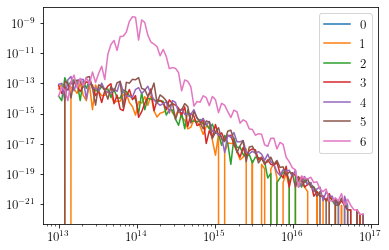

In [110]:
plt.plot(rs, np.abs((pops_0[-1]-pops_0[-1]).reshape((100, 2))[:,0]), label=0)
plt.plot(rs, np.abs((pops_1[-1]-pops_0[-1]).reshape((100, 2))[:,0]), label=1)
plt.plot(rs, np.abs((pops_2[-1]-pops_0[-1]).reshape((100, 2))[:,0]), label=2)
plt.plot(rs, np.abs((pops_3[-1]-pops_0[-1]).reshape((100, 2))[:,0]), label=3)
plt.plot(rs, np.abs((pops_4[-1]-pops_0[-1]).reshape((100, 2))[:,0]), label=4)
plt.plot(rs, np.abs((pops_5[-1]-pops_0[-1]).reshape((100, 2))[:,0]), label=5)
plt.plot(rs, np.abs((pops_6[-1]-pops_0[-1]).reshape((100, 2))[:,0]), label=6)
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [220]:
diff_Jeff= np.max(0.5*np.abs(Jeffs_0[1:]-Jeffs_0[:-1])/np.abs(Jeffs_0[1:]+Jeffs_0[:-1]), axis=1)

ValueError: x and y must have same first dimension, but have shapes (100,) and (99, 100, 1)

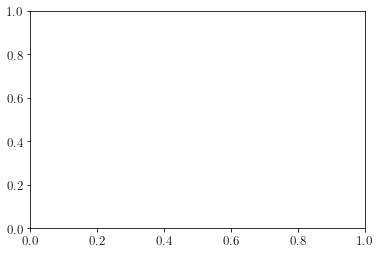

In [213]:
plt.plot(rs, np.abs((Jeffs_0[1:]-Jeffs_0[:-1])), label=0)

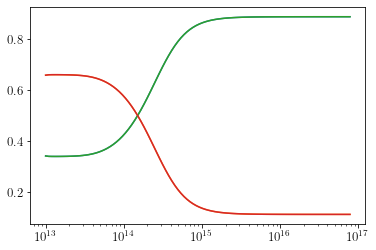

In [34]:
plt.plot(rs, pops_1[-1].reshape((100, 2))[:,0]/nTT(rs))
plt.plot(rs, pops_1[-1].reshape((100, 2))[:,1]/nTT(rs))
plt.plot(rs, pops_6[-1].reshape((100, 2))[:,0]/nTT(rs))
plt.plot(rs, pops_6[-1].reshape((100, 2))[:,1]/nTT(rs))
plt.xscale('log')

In [5]:
d0 = np.abs(0.5 * (pops_0-pops_0[-1]) / (pops_0+pops_0[-1]))
d1 = np.abs(0.5 * (pops_1-pops_1[-1]) / (pops_1+pops_1[-1]))
d2 = np.abs(0.5 * (pops_2-pops_2[-1]) / (pops_2+pops_2[-1]))
d3 = np.abs(0.5 * (pops_3-pops_3[-1]) / (pops_3+pops_3[-1]))
d4 = np.abs(0.5 * (pops_4-pops_4[-1]) / (pops_4+pops_4[-1]))
d5 = np.abs(0.5 * (pops_5-pops_5[-1]) / (pops_5+pops_5[-1]))
d6 = np.abs(0.5 * (pops_6-pops_6[-1]) / (pops_6+pops_6[-1]))

In [6]:
D0 = (0.5 * (pops_0-pops_0[-1]) / (pops_0+pops_0[-1]))
D1 = (0.5 * (pops_1-pops_1[-1]) / (pops_1+pops_1[-1]))
D2 = (0.5 * (pops_2-pops_2[-1]) / (pops_2+pops_2[-1]))
D3 = (0.5 * (pops_3-pops_3[-1]) / (pops_3+pops_3[-1]))
D4 = (0.5 * (pops_4-pops_4[-1]) / (pops_4+pops_4[-1]))
D5 = (0.5 * (pops_5-pops_5[-1]) / (pops_5+pops_5[-1]))
D6 = (0.5 * (pops_6-pops_6[-1]) / (pops_6+pops_6[-1]))

In [7]:
D0

array([[-1.75524674e-03,  9.05703579e-04, -5.65823537e-04, ...,
         3.54881994e-01, -2.23574325e-01,  3.54882582e-01],
       [-5.93833995e-06,  3.08045200e-06, -1.51175233e-05, ...,
         1.31648551e-02, -1.39995730e-03,  1.08102128e-02],
       [-2.80705508e-06,  1.45614443e-06, -4.89925131e-06, ...,
         6.19099391e-04, -6.51577822e-05,  5.15096296e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      dtype=float128)

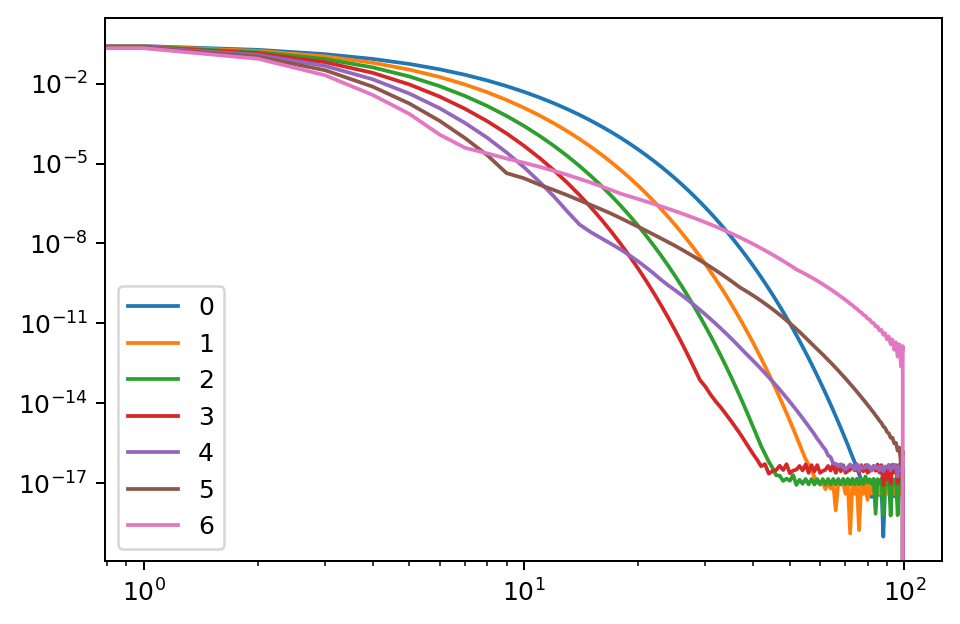

In [12]:
plt.figure(dpi=180)
plt.plot((np.max(d0,axis=1)), label=0)
plt.plot((np.max(d1,axis=1)), label=1)
plt.plot((np.max(d2,axis=1)), label=2)
plt.plot((np.max(d3,axis=1)), label=3)
plt.plot((np.max(d4,axis=1)), label=4)
plt.plot((np.max(d5,axis=1)), label=5)
plt.plot((np.max(d6,axis=1)), label=6)
# plt.plot(diff_Jeff, c='k')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [13]:
np.log(np.max(d0,axis=1))

/home/frederik/software/Anaconda3/installation/envs/magritte_2/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([ -1.0359683 ,  -1.35038357,  -1.68080014,  -2.05270521,
        -2.46332946,  -2.90150055,  -3.36248529,  -3.83754488,
        -4.32411837,  -4.81725745,  -5.31191198,  -5.80939217,
        -6.30852141,  -6.80860521,  -7.3092366 ,  -7.81017845,
        -8.31129337,  -8.81250233,  -9.31376038,  -9.81504234,
       -10.31633442, -10.81762936, -11.31892356, -11.82021543,
       -12.32150447, -12.82279071, -13.32407442, -13.82535598,
       -14.32663574, -14.82791404, -15.32919119, -15.83046741,
       -16.33174291, -16.83301784, -17.33429234, -17.8355665 ,
       -18.33684039, -18.83811408, -19.33938761, -19.84066103,
       -20.34193435, -20.8432076 , -21.34448079, -21.84575395,
       -22.34702705, -22.84830014, -23.34957322, -23.85084623,
       -24.35211922, -24.85339222, -25.35466535, -25.85593797,
       -26.35721031, -26.85848313, -27.35975702, -27.86102501,
       -28.36229126, -28.86356692, -29.36482245, -29.86610128,
       -30.36736044, -30.86864588, -31.36976027, -31.87

/home/frederik/software/Anaconda3/installation/envs/magritte_2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/frederik/software/Anaconda3/installation/envs/magritte_2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/frederik/software/Anaconda3/installation/envs/magritte_2/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/frederik/software/Anaconda3/installation/envs/magritte_2/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/frederik/software/Anaconda3/installation/envs/magritte_2/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/frederik/software/Anaconda3/in

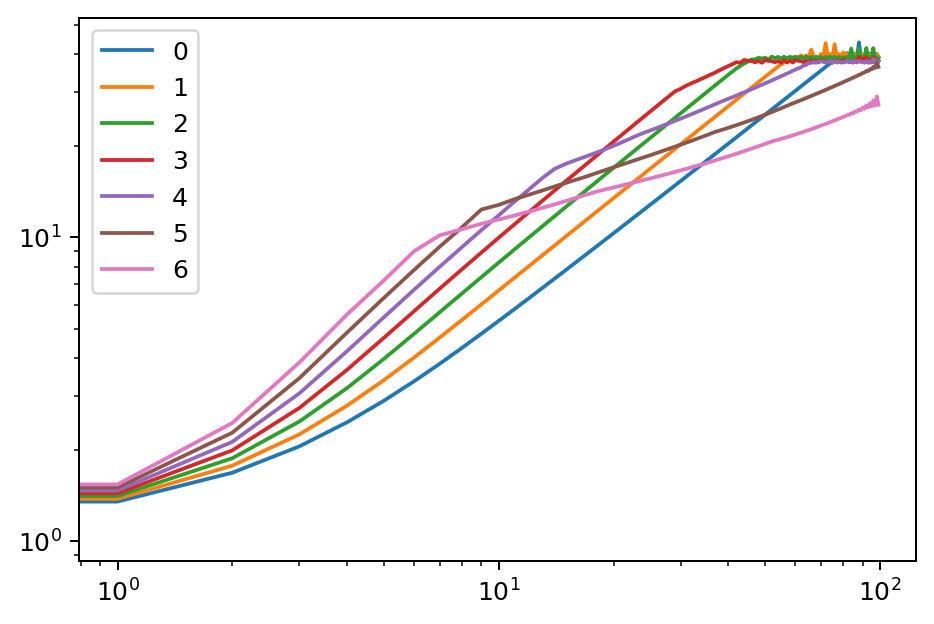

In [19]:
plt.figure(dpi=180)
plt.plot(-np.log(np.max(d0,axis=1))[:-1], label=0)
plt.plot(-np.log(np.max(d1,axis=1)), label=1)
plt.plot(-np.log(np.max(d2,axis=1)), label=2)
plt.plot(-np.log(np.max(d3,axis=1)), label=3)
plt.plot(-np.log(np.max(d4,axis=1)), label=4)
plt.plot(-np.log(np.max(d5,axis=1)), label=5)
plt.plot(-np.log(np.max(d6,axis=1)), label=6)
plt.yscale('log')
plt.xscale('log')
plt.legend()

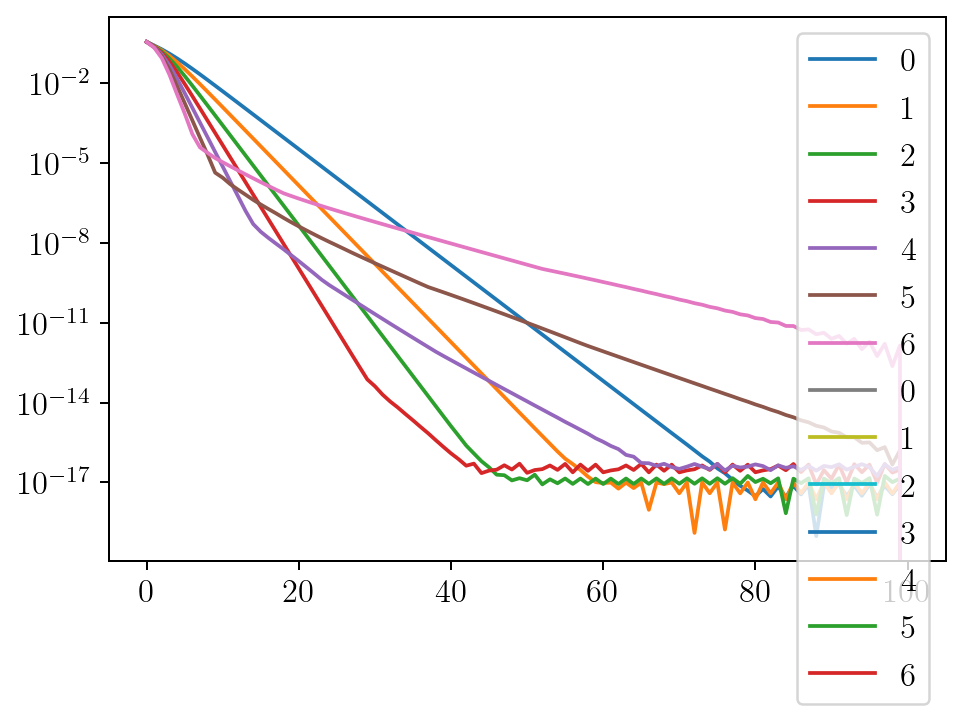

In [203]:
plt.figure(dpi=180)
plt.plot(np.max(d0,axis=1), label=0)
plt.plot(np.max(d1,axis=1), label=1)
plt.plot(np.max(d2,axis=1), label=2)
plt.plot(np.max(d3,axis=1), label=3)
plt.plot(np.max(d4,axis=1), label=4)
plt.plot(np.max(d5,axis=1), label=5)
plt.plot(np.max(d6,axis=1), label=6)

plt.plot(np.min(D0,axis=1), label=0)
plt.plot(np.min(D1,axis=1), label=1)
plt.plot(np.min(D2,axis=1), label=2)
plt.plot(np.min(D3,axis=1), label=3)
plt.plot(np.min(D4,axis=1), label=4)
plt.plot(np.min(D5,axis=1), label=5)
plt.plot(np.min(D6,axis=1), label=6)

plt.yscale('log')
plt.legend()

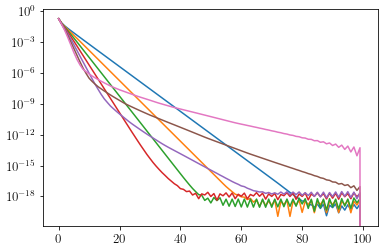

In [111]:
plt.plot(np.mean(d0,axis=1))
plt.plot(np.mean(d1,axis=1))
plt.plot(np.mean(d2,axis=1))
plt.plot(np.mean(d3,axis=1))
plt.plot(np.mean(d4,axis=1))
plt.plot(np.mean(d5,axis=1))
plt.plot(np.mean(d6,axis=1))
plt.yscale('log')

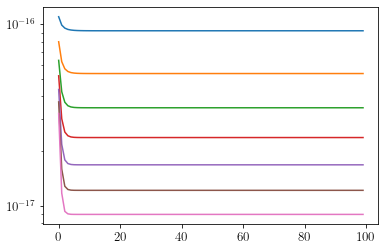

In [87]:
plt.plot(np.max(Jeffs_0, axis=1))
plt.plot(np.max(Jeffs_1, axis=1))
plt.plot(np.max(Jeffs_2, axis=1))
plt.plot(np.max(Jeffs_3, axis=1))
plt.plot(np.max(Jeffs_4, axis=1))
plt.plot(np.max(Jeffs_5, axis=1))
plt.plot(np.max(Jeffs_6, axis=1))
plt.yscale('log')

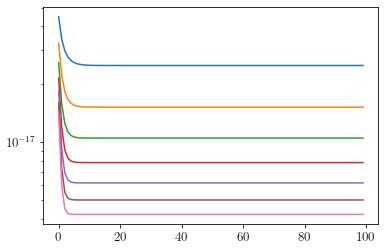

In [88]:
plt.plot(np.mean(Jeffs_0, axis=1))
plt.plot(np.mean(Jeffs_1, axis=1))
plt.plot(np.mean(Jeffs_2, axis=1))
plt.plot(np.mean(Jeffs_3, axis=1))
plt.plot(np.mean(Jeffs_4, axis=1))
plt.plot(np.mean(Jeffs_5, axis=1))
plt.plot(np.mean(Jeffs_6, axis=1))
plt.yscale('log')

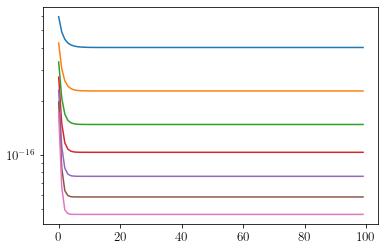

In [91]:
plt.plot(np.linalg.norm(Jeffs_0, axis=1))
plt.plot(np.linalg.norm(Jeffs_1, axis=1))
plt.plot(np.linalg.norm(Jeffs_2, axis=1))
plt.plot(np.linalg.norm(Jeffs_3, axis=1))
plt.plot(np.linalg.norm(Jeffs_4, axis=1))
plt.plot(np.linalg.norm(Jeffs_5, axis=1))
plt.plot(np.linalg.norm(Jeffs_6, axis=1))
plt.yscale('log')

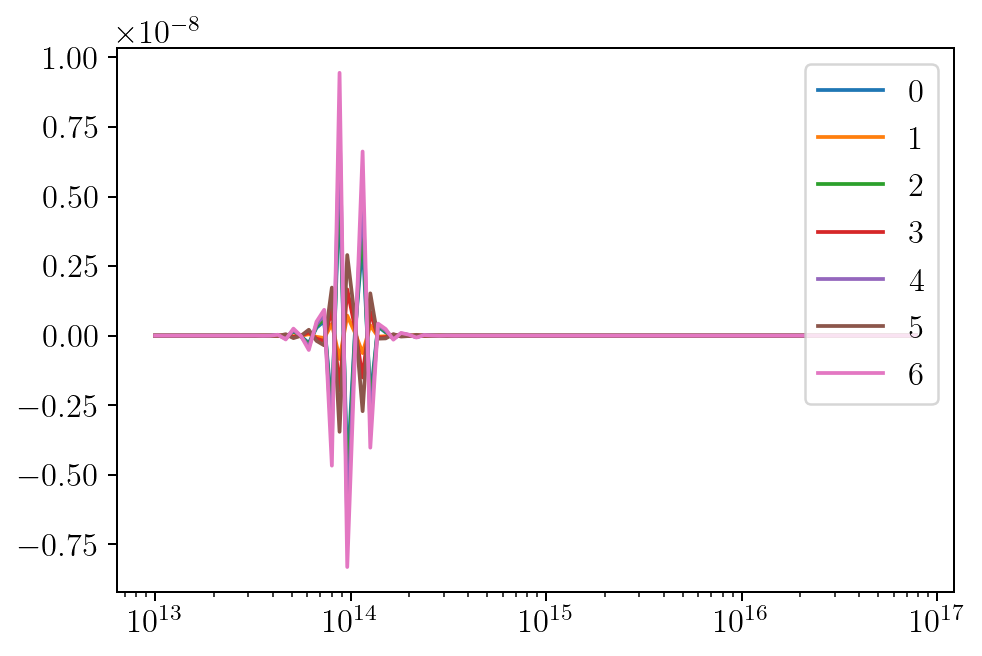

In [107]:
plt.figure(dpi=180)
plt.plot(rs, (pops_6[-2]-pops_6[-1]).reshape((100, 2))[:,0], label=0)
plt.plot(rs, (pops_6[-3]-pops_6[-1]).reshape((100, 2))[:,0], label=1)
plt.plot(rs, (pops_6[-4]-pops_6[-1]).reshape((100, 2))[:,0], label=2)
plt.plot(rs, (pops_6[-5]-pops_6[-1]).reshape((100, 2))[:,0], label=3)
plt.plot(rs, (pops_6[-6]-pops_6[-1]).reshape((100, 2))[:,0], label=4)
plt.plot(rs, (pops_6[-7]-pops_6[-1]).reshape((100, 2))[:,0], label=5)
plt.plot(rs, (pops_6[-8]-pops_6[-1]).reshape((100, 2))[:,0], label=6)
plt.xscale('log')
# plt.yscale('log')
plt.legend()

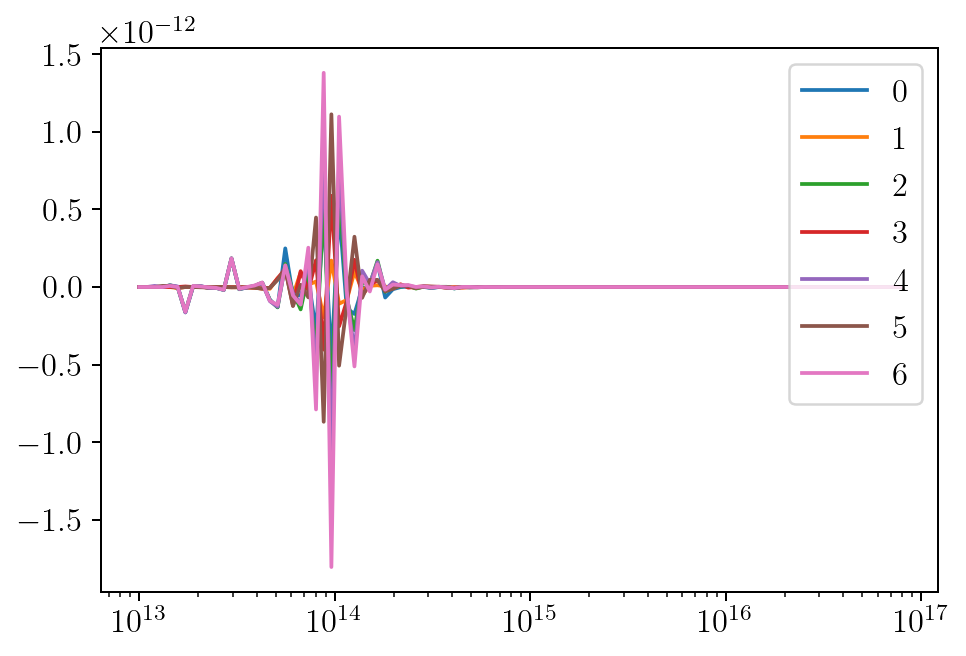

In [108]:
plt.figure(dpi=180)
plt.plot(rs, (pops_5[-2]-pops_5[-1]).reshape((100, 2))[:,0], label=0)
plt.plot(rs, (pops_5[-3]-pops_5[-1]).reshape((100, 2))[:,0], label=1)
plt.plot(rs, (pops_5[-4]-pops_5[-1]).reshape((100, 2))[:,0], label=2)
plt.plot(rs, (pops_5[-5]-pops_5[-1]).reshape((100, 2))[:,0], label=3)
plt.plot(rs, (pops_5[-6]-pops_5[-1]).reshape((100, 2))[:,0], label=4)
plt.plot(rs, (pops_5[-7]-pops_5[-1]).reshape((100, 2))[:,0], label=5)
plt.plot(rs, (pops_5[-8]-pops_5[-1]).reshape((100, 2))[:,0], label=6)
plt.xscale('log')
# plt.yscale('log')
plt.legend()

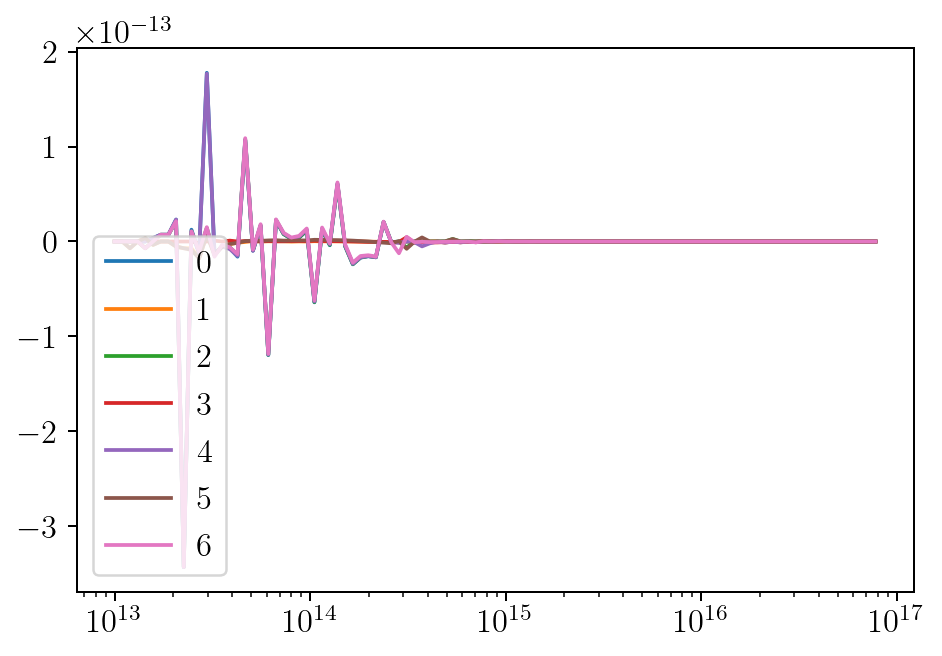

In [112]:
plt.figure(dpi=180)
plt.plot(rs, (pops_4[-2]-pops_4[-1]).reshape((100, 2))[:,0], label=0)
plt.plot(rs, (pops_4[-3]-pops_4[-1]).reshape((100, 2))[:,0], label=1)
plt.plot(rs, (pops_4[-4]-pops_4[-1]).reshape((100, 2))[:,0], label=2)
plt.plot(rs, (pops_4[-5]-pops_4[-1]).reshape((100, 2))[:,0], label=3)
plt.plot(rs, (pops_4[-6]-pops_4[-1]).reshape((100, 2))[:,0], label=4)
plt.plot(rs, (pops_4[-7]-pops_4[-1]).reshape((100, 2))[:,0], label=5)
plt.plot(rs, (pops_4[-8]-pops_4[-1]).reshape((100, 2))[:,0], label=6)
plt.xscale('log')
# plt.yscale('log')
plt.legend()

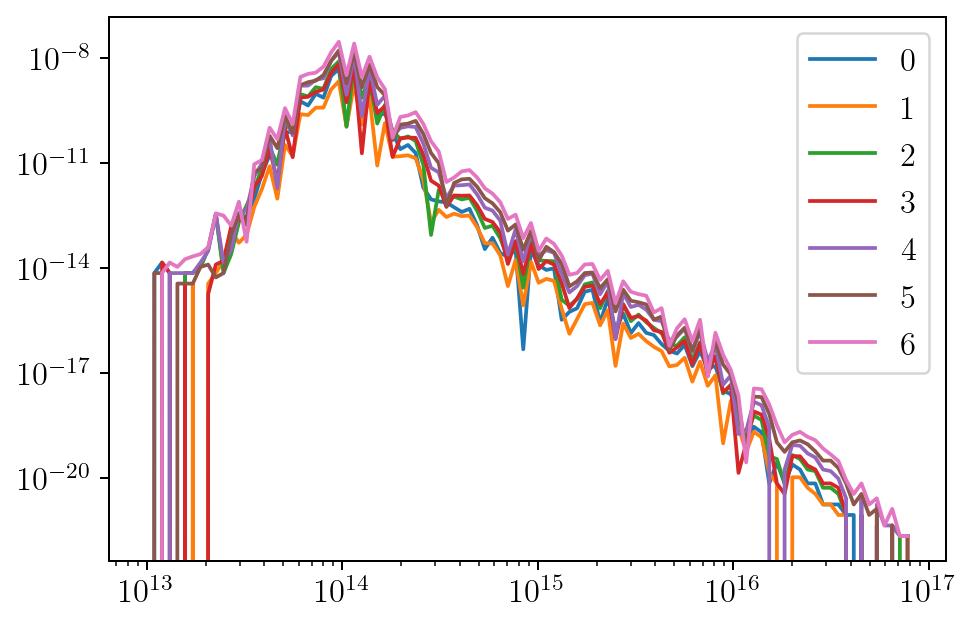

In [116]:
plt.figure(dpi=180)
plt.plot(rs, np.abs(pops_4[40-2]-pops_4[40-1]).reshape((100, 2))[:,0], label=0)
plt.plot(rs, np.abs(pops_4[40-3]-pops_4[40-1]).reshape((100, 2))[:,0], label=1)
plt.plot(rs, np.abs(pops_4[40-4]-pops_4[40-1]).reshape((100, 2))[:,0], label=2)
plt.plot(rs, np.abs(pops_4[40-5]-pops_4[40-1]).reshape((100, 2))[:,0], label=3)
plt.plot(rs, np.abs(pops_4[40-6]-pops_4[40-1]).reshape((100, 2))[:,0], label=4)
plt.plot(rs, np.abs(pops_4[40-7]-pops_4[40-1]).reshape((100, 2))[:,0], label=5)
plt.plot(rs, np.abs(pops_4[40-8]-pops_4[40-1]).reshape((100, 2))[:,0], label=6)
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [158]:
def plot_0(it):
    plt.figure(dpi=180)
    plt.plot(rs, (pops_0[it-2]-pops_0[it-1]).reshape((100, 2))[:,0], label=0)
    plt.plot(rs, (pops_0[it-3]-pops_0[it-1]).reshape((100, 2))[:,0], label=1)
    plt.plot(rs, (pops_0[it-4]-pops_0[it-1]).reshape((100, 2))[:,0], label=2)
    plt.plot(rs, (pops_0[it-5]-pops_0[it-1]).reshape((100, 2))[:,0], label=3)
    plt.plot(rs, (pops_0[it-6]-pops_0[it-1]).reshape((100, 2))[:,0], label=4)
    plt.plot(rs, (pops_0[it-7]-pops_0[it-1]).reshape((100, 2))[:,0], label=5)
    plt.plot(rs, (pops_0[it-8]-pops_0[it-1]).reshape((100, 2))[:,0], label=6)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim((1.0e-20, 1.0e2))
    plt.legend()

In [166]:
def plot_2(it):
    fig, axis = plt.subplots(2, dpi=180)
    
    ax1 = axis[0]
    ax2 = axis[1]
    
#     ax1 = fig.add_subplot()
    ax1.plot(rs, (0.5*(pops_2[it-2]-pops_2[it-1])/(pops_2[it-2]+pops_2[it-1])).reshape((100, 2))[:,0], label=0)
    ax1.plot(rs, (0.5*(pops_2[it-3]-pops_2[it-1])/(pops_2[it-3]+pops_2[it-1])).reshape((100, 2))[:,0], label=1)
    ax1.plot(rs, (0.5*(pops_2[it-4]-pops_2[it-1])/(pops_2[it-4]+pops_2[it-1])).reshape((100, 2))[:,0], label=2)
    ax1.plot(rs, (0.5*(pops_2[it-5]-pops_2[it-1])/(pops_2[it-5]+pops_2[it-1])).reshape((100, 2))[:,0], label=3)
    ax1.plot(rs, (0.5*(pops_2[it-6]-pops_2[it-1])/(pops_2[it-6]+pops_2[it-1])).reshape((100, 2))[:,0], label=4)
    ax1.plot(rs, (0.5*(pops_2[it-7]-pops_2[it-1])/(pops_2[it-7]+pops_2[it-1])).reshape((100, 2))[:,0], label=5)
    ax1.plot(rs, (0.5*(pops_2[it-8]-pops_2[it-1])/(pops_2[it-8]+pops_2[it-1])).reshape((100, 2))[:,0], label=6)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylim((1.0e-20, 1.0e2))
    ax1.legend()
    
#     ax2 = fig.add_subplot()
    ax2.plot(rs, -(0.5*(pops_2[it-2]-pops_2[it-1])/(pops_2[it-2]+pops_2[it-1])).reshape((100, 2))[:,0], label=0)
    ax2.plot(rs, -(0.5*(pops_2[it-3]-pops_2[it-1])/(pops_2[it-3]+pops_2[it-1])).reshape((100, 2))[:,0], label=1)
    ax2.plot(rs, -(0.5*(pops_2[it-4]-pops_2[it-1])/(pops_2[it-4]+pops_2[it-1])).reshape((100, 2))[:,0], label=2)
    ax2.plot(rs, -(0.5*(pops_2[it-5]-pops_2[it-1])/(pops_2[it-5]+pops_2[it-1])).reshape((100, 2))[:,0], label=3)
    ax2.plot(rs, -(0.5*(pops_2[it-6]-pops_2[it-1])/(pops_2[it-6]+pops_2[it-1])).reshape((100, 2))[:,0], label=4)
    ax2.plot(rs, -(0.5*(pops_2[it-7]-pops_2[it-1])/(pops_2[it-7]+pops_2[it-1])).reshape((100, 2))[:,0], label=5)
    ax2.plot(rs, -(0.5*(pops_2[it-8]-pops_2[it-1])/(pops_2[it-8]+pops_2[it-1])).reshape((100, 2))[:,0], label=6)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylim((1.0e-20, 1.0e2))
    ax2.legend()

In [159]:
def plot_4(it):
    fig, axis = plt.subplots(2, dpi=180)
    
    ax1 = axis[0]
    ax2 = axis[1]
    
#     ax1 = fig.add_subplot()
    ax1.plot(rs, (pops_4[it-2]-pops_4[it-1]).reshape((100, 2))[:,0], label=0)
    ax1.plot(rs, (pops_4[it-3]-pops_4[it-1]).reshape((100, 2))[:,0], label=1)
    ax1.plot(rs, (pops_4[it-4]-pops_4[it-1]).reshape((100, 2))[:,0], label=2)
    ax1.plot(rs, (pops_4[it-5]-pops_4[it-1]).reshape((100, 2))[:,0], label=3)
    ax1.plot(rs, (pops_4[it-6]-pops_4[it-1]).reshape((100, 2))[:,0], label=4)
    ax1.plot(rs, (pops_4[it-7]-pops_4[it-1]).reshape((100, 2))[:,0], label=5)
    ax1.plot(rs, (pops_4[it-8]-pops_4[it-1]).reshape((100, 2))[:,0], label=6)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylim((1.0e-20, 1.0e2))
    ax1.legend()
    
#     ax2 = fig.add_subplot()
    ax2.plot(rs, -(pops_4[it-2]-pops_4[it-1]).reshape((100, 2))[:,0], label=0)
    ax2.plot(rs, -(pops_4[it-3]-pops_4[it-1]).reshape((100, 2))[:,0], label=1)
    ax2.plot(rs, -(pops_4[it-4]-pops_4[it-1]).reshape((100, 2))[:,0], label=2)
    ax2.plot(rs, -(pops_4[it-5]-pops_4[it-1]).reshape((100, 2))[:,0], label=3)
    ax2.plot(rs, -(pops_4[it-6]-pops_4[it-1]).reshape((100, 2))[:,0], label=4)
    ax2.plot(rs, -(pops_4[it-7]-pops_4[it-1]).reshape((100, 2))[:,0], label=5)
    ax2.plot(rs, -(pops_4[it-8]-pops_4[it-1]).reshape((100, 2))[:,0], label=6)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylim((1.0e-20, 1.0e2))
    ax2.legend()

In [160]:
from ipywidgets import interact

In [161]:
interact(plot_4, it=(10, 99))

interactive(children=(IntSlider(value=54, description='it', max=99, min=10), Output()), _dom_classes=('widget-…

<function __main__.plot_4(it)>

In [167]:
interact(plot_2, it=(10, 99))

interactive(children=(IntSlider(value=54, description='it', max=99, min=10), Output()), _dom_classes=('widget-…

<function __main__.plot_2(it)>

In [162]:
interact(plot_0, it=(10, 99))

interactive(children=(IntSlider(value=54, description='it', max=99, min=10), Output()), _dom_classes=('widget-…

<function __main__.plot_0(it)>

(-5.0, 55.0)

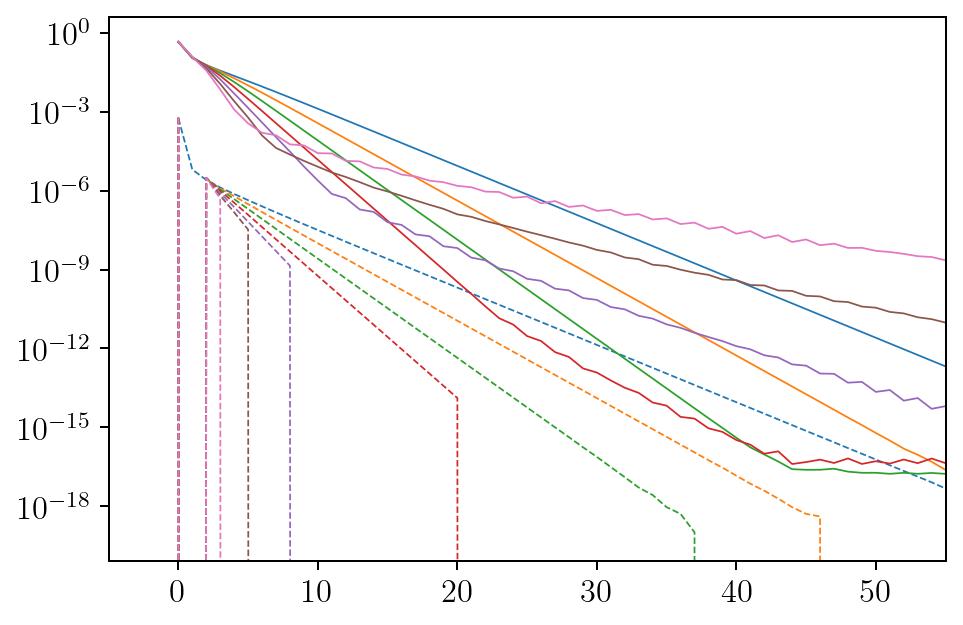

In [205]:
plt.figure(dpi=180)
plt.plot(np.max(((pops_0[1:] - pops_0[:-1])/(pops_0[1:] + pops_0[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C0')
plt.plot(np.min(((pops_0[1:] - pops_0[:-1])/(pops_0[1:] + pops_0[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C0',linestyle='dashed')
plt.plot(np.max(((pops_1[1:] - pops_1[:-1])/(pops_1[1:] + pops_1[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C1')
plt.plot(np.min(((pops_1[1:] - pops_1[:-1])/(pops_1[1:] + pops_1[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C1',linestyle='dashed')
plt.plot(np.max(((pops_2[1:] - pops_2[:-1])/(pops_2[1:] + pops_2[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C2')
plt.plot(np.min(((pops_2[1:] - pops_2[:-1])/(pops_2[1:] + pops_2[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C2',linestyle='dashed')
plt.plot(np.max(((pops_3[1:] - pops_3[:-1])/(pops_3[1:] + pops_3[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C3')
plt.plot(np.min(((pops_3[1:] - pops_3[:-1])/(pops_3[1:] + pops_3[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C3',linestyle='dashed')
plt.plot(np.max(((pops_4[1:] - pops_4[:-1])/(pops_4[1:] + pops_4[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C4')
plt.plot(np.min(((pops_4[1:] - pops_4[:-1])/(pops_4[1:] + pops_4[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C4',linestyle='dashed')
plt.plot(np.max(((pops_5[1:] - pops_5[:-1])/(pops_5[1:] + pops_5[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C5')
plt.plot(np.min(((pops_5[1:] - pops_5[:-1])/(pops_5[1:] + pops_5[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C5',linestyle='dashed')
plt.plot(np.max(((pops_6[1:] - pops_6[:-1])/(pops_6[1:] + pops_6[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C6')
plt.plot(np.min(((pops_6[1:] - pops_6[:-1])/(pops_6[1:] + pops_6[:-1])).reshape((100, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C6',linestyle='dashed')
plt.yscale('log')
plt.xlim((-5, 55))

(-5.0, 55.0)

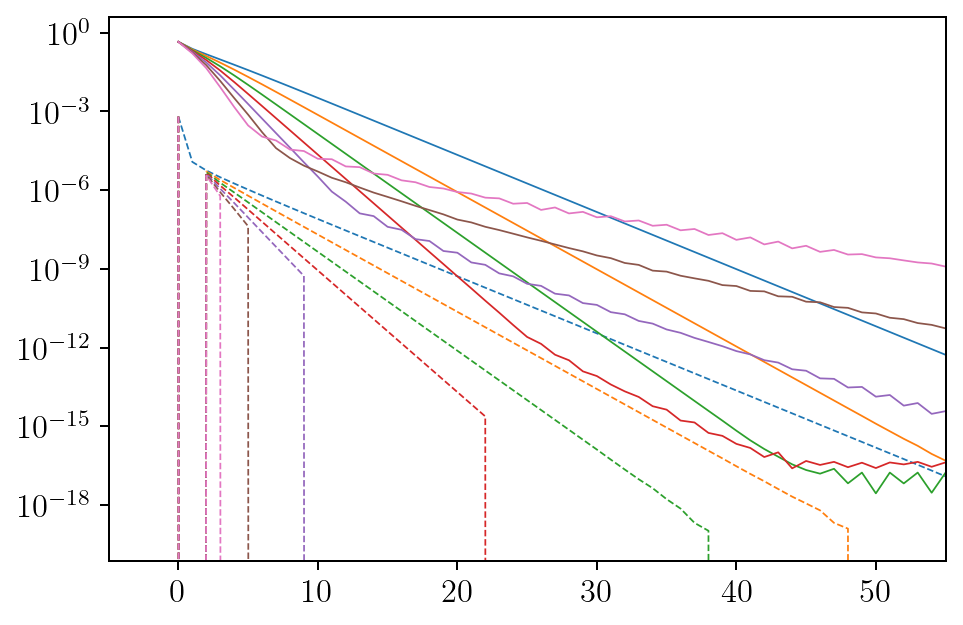

In [208]:
plt.figure(dpi=180)
plt.plot(np.max((-(pops_0 - pops_0[-1])/(pops_0 + pops_0[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C0')
plt.plot(np.min((-(pops_0 - pops_0[-1])/(pops_0 + pops_0[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C0',linestyle='dashed')
plt.plot(np.max((-(pops_1 - pops_1[-1])/(pops_1 + pops_1[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C1')
plt.plot(np.min((-(pops_1 - pops_1[-1])/(pops_1 + pops_1[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C1',linestyle='dashed')
plt.plot(np.max((-(pops_2 - pops_2[-1])/(pops_2 + pops_2[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C2')
plt.plot(np.min((-(pops_2 - pops_2[-1])/(pops_2 + pops_2[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C2',linestyle='dashed')
plt.plot(np.max((-(pops_3 - pops_3[-1])/(pops_3 + pops_3[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C3')
plt.plot(np.min((-(pops_3 - pops_3[-1])/(pops_3 + pops_3[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C3',linestyle='dashed')
plt.plot(np.max((-(pops_4 - pops_4[-1])/(pops_4 + pops_4[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C4')
plt.plot(np.min((-(pops_4 - pops_4[-1])/(pops_4 + pops_4[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C4',linestyle='dashed')
plt.plot(np.max((-(pops_5 - pops_5[-1])/(pops_5 + pops_5[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C5')
plt.plot(np.min((-(pops_5 - pops_5[-1])/(pops_5 + pops_5[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C5',linestyle='dashed')
plt.plot(np.max((-(pops_6 - pops_6[-1])/(pops_6 + pops_6[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C6')
plt.plot(np.min((-(pops_6 - pops_6[-1])/(pops_6 + pops_6[-1])).reshape((101, 100, 2))[:,:,0], axis=1), linewidth=.7, c='C6',linestyle='dashed')
plt.yscale('log')
plt.xlim((-5, 55))

In [175]:
(pops_4[1:] - pops_4[:-1]).reshape((100, 100, 2))[:,0]

array([[ 4.82607974e+02, -4.82607974e+02],
       [-5.23449749e+00,  5.23449749e+00],
       [ 4.16663354e-01, -4.16663354e-01],
       [ 1.10069080e-01, -1.10069080e-01],
       [ 3.20137688e-02, -3.20137688e-02],
       [ 8.88653358e-03, -8.88653358e-03],
       [ 2.45832661e-03, -2.45832661e-03],
       [ 6.82156083e-04, -6.82156083e-04],
       [ 1.89710248e-04, -1.89710248e-04],
       [ 5.28858028e-05, -5.28858028e-05],
       [ 1.47357326e-05, -1.47357326e-05],
       [ 4.11537708e-06, -4.11537708e-06],
       [ 1.14605082e-06, -1.14605082e-06],
       [ 3.20612145e-07, -3.20612145e-07],
       [ 8.91155025e-08, -8.91155025e-08],
       [ 2.49878411e-08, -2.49878411e-08],
       [ 6.93401603e-09, -6.93401603e-09],
       [ 1.94114591e-09, -1.94114591e-09],
       [ 5.45171019e-10, -5.45171019e-10],
       [ 1.46798129e-10, -1.46798129e-10],
       [ 4.54178917e-11, -4.54178917e-11],
       [ 9.43600753e-12, -9.43600753e-12],
       [ 4.81747975e-12, -4.81747975e-12],
       [ 0.

In [170]:
pops_4[:-1].shape

(100, 200)

The reason for worse convergence is that it quickly becomes non-monotonic 

In [122]:
Jeffs_0

array([[[3.80160044e-17],
        [4.99913195e-17],
        [6.35094332e-17],
        ...,
        [4.06299455e-18],
        [4.01479337e-18],
        [3.97040797e-18]],

       [[3.72462445e-17],
        [4.91440146e-17],
        [6.27788879e-17],
        ...,
        [3.78223570e-18],
        [3.78036682e-18],
        [3.78024133e-18]],

       [[3.71942911e-17],
        [4.90641094e-17],
        [6.26639419e-17],
        ...,
        [3.77115822e-18],
        [3.77116420e-18],
        [3.77262641e-18]],

       ...,

       [[3.71327724e-17],
        [4.89726602e-17],
        [6.25372622e-17],
        ...,
        [3.76899794e-18],
        [3.76933680e-18],
        [3.77107580e-18]],

       [[3.71327724e-17],
        [4.89726602e-17],
        [6.25372622e-17],
        ...,
        [3.76899794e-18],
        [3.76933680e-18],
        [3.77107580e-18]],

       [[3.71327724e-17],
        [4.89726602e-17],
        [6.25372622e-17],
        ...,
        [3.76899794e-18],
        [3.7693

In [9]:
from matplotlib import pyplot   as plt
from matplotlib import gridspec, rcParams, rc, cm, colors

rcParams.update({'font.size': 13})
rc('text', usetex=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

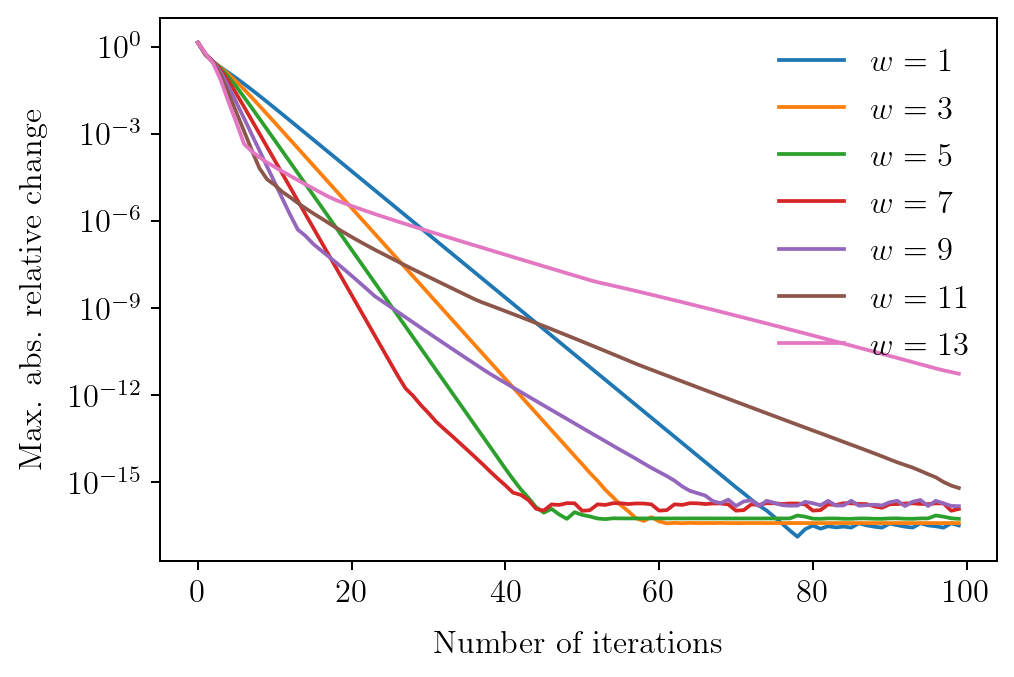

In [10]:
plt.figure(dpi=180)
plt.plot(max_diffs_0, label='$w=1$')
plt.plot(max_diffs_1, label='$w=3$')
plt.plot(max_diffs_2, label='$w=5$')
plt.plot(max_diffs_3, label='$w=7$')
plt.plot(max_diffs_4, label='$w=9$')
plt.plot(max_diffs_5, label='$w=11$')
plt.plot(max_diffs_6, label='$w=13$')
plt.yscale('log')
# plt.ylim((5.0e-14, 2))
plt.xlabel('Number of iterations',    labelpad=9)
plt.ylabel('Max. abs. relative change', labelpad=9)
plt.legend(frameon=False, fancybox=False)

# plt.savefig('ALOs.pdf', bbox_inches='tight')

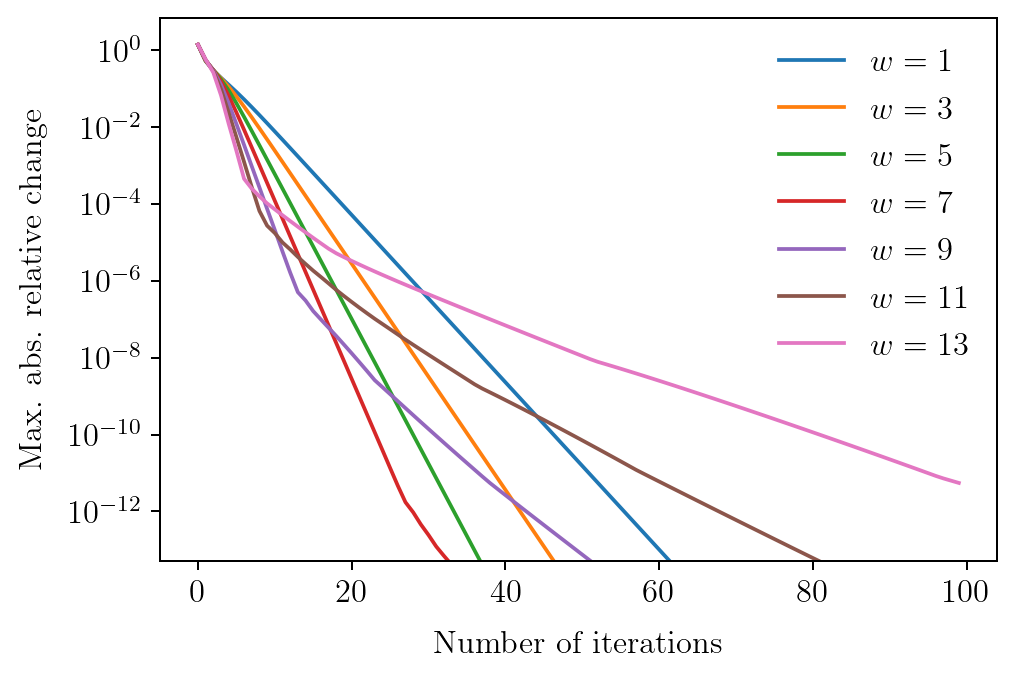

In [15]:
plt.figure(dpi=180)
plt.plot(max_diffs_0, label='$w=1$')
plt.plot(max_diffs_1, label='$w=3$')
plt.plot(max_diffs_2, label='$w=5$')
plt.plot(max_diffs_3, label='$w=7$')
plt.plot(max_diffs_4, label='$w=9$')
plt.plot(max_diffs_5, label='$w=11$')
plt.plot(max_diffs_6, label='$w=13$')
plt.yscale('log')
plt.ylim((5.0e-14, 7))
plt.xlabel('Number of iterations',      labelpad=9)
plt.ylabel('Max. abs. relative change', labelpad=9)
plt.legend(frameon=False, fancybox=False)

plt.savefig('ALOs.pdf', bbox_inches='tight')

In [ ]:
def Ng_acceleration(pops, order):
    
    if len(pops)%order != 0
    

In [12]:
Ys = np.array(pops, dtype=float)
Ys = Ys[5:,:]
Es1 = []
Es2 = []

for i in range(2, Ys.shape[0]+1):
#     print(i)
    ys = Ys[:i,:]
    rs = ys[1:,:] - ys[:-1,:]
    cs1 = np.linalg.solve(np.matmul(rs, rs.T), np.ones(rs.shape[0]))
    cs1 = cs1 / np.sum(cs1)
    cs2 = np.linalg.solve(np.matmul(rs, rs.T) + 1.0e-6*np.eye(rs.shape[0]), np.ones(rs.shape[0]))
    cs2 = cs2 / np.sum(cs2)
    nw1 = np.matmul(cs1, ys[:-1,:])
    nw2 = np.matmul(cs2, ys[:-1,:])
    Es1.append(nw1)
    Es2.append(nw2)
    
Es1 = np.array(Es1)
Es2 = np.array(Es2)
Ds1 = np.max(Es1[1:,:] - Es1[:-1,:], axis=1)
Ds2 = np.max(Es2[1:,:] - Es2[:-1,:], axis=1)

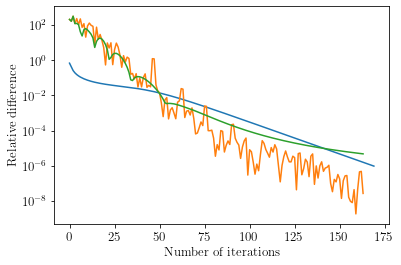

In [17]:
plt.plot(max_diffs)
plt.plot(Ds1)
plt.plot(Ds2)
plt.xlabel('Number of iterations')
plt.ylabel('Relative difference')
plt.yscale('log')

In [43]:
Ds

(164,)

In [11]:
ys = np.array(pops, dtype=float)

In [12]:
ys.shape

(166, 200)

In [14]:
R = ys[1:,:] - ys[:-1,:]

In [15]:
R.shape

(165, 200)

In [22]:
cs = np.linalg.solve(np.matmul(R, R.T), np.ones(R.shape[0]))
cs = cs / np.sum(cs)

In [20]:
np.linalg.cond(np.matmul(R, R.T))

9.040704754521604e+25

In [26]:
new1 = np.matmul(cs, ys[1:,:])
new2 = np.matmul(cs, ys[:-1,:])

array([ 1.86264515e-09, -1.86264515e-09, -9.31322575e-10,  0.00000000e+00,
       -9.31322575e-10,  1.86264515e-09, -9.31322575e-10,  0.00000000e+00,
        0.00000000e+00, -1.86264515e-09,  0.00000000e+00,  9.31322575e-10,
       -9.31322575e-10,  9.31322575e-10,  2.32830644e-10,  1.39698386e-09,
        2.32830644e-10, -4.65661287e-10,  2.32830644e-10,  0.00000000e+00,
        2.32830644e-10,  0.00000000e+00, -1.16415322e-10,  0.00000000e+00,
       -2.32830644e-10,  6.98491931e-10, -1.16415322e-10,  2.32830644e-10,
        1.16415322e-10,  0.00000000e+00, -1.16415322e-10,  1.16415322e-10,
        5.82076609e-11,  0.00000000e+00, -5.82076609e-11,  0.00000000e+00,
       -5.82076609e-11, -1.16415322e-10,  2.91038305e-11,  1.74622983e-10,
       -2.91038305e-11,  0.00000000e+00,  2.91038305e-11, -5.82076609e-11,
       -4.36557457e-11,  0.00000000e+00, -4.36557457e-11, -5.82076609e-11,
        0.00000000e+00,  5.82076609e-11,  0.00000000e+00,  0.00000000e+00,
       -1.45519152e-11,  